# Régression logistique et convexité

La régression logistique est un modèle de classification binaire, simple à interpréter mais limité dans la gamme des problèmes qu'il peut résoudre. Limité comment ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un jeu de données

Non convexe.

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, labels_true = make_blobs(n_samples=750, centers=6, cluster_std=0.4)
labels_true = labels_true % 3

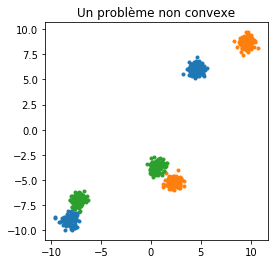

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(max(labels_true) + 1):
    ax.plot(X[labels_true==i, 0], X[labels_true==i, 1], '.', label='c%d' % i)
ax.set_title("Un problème non convexe");

## Deux modèles

Comparons une régression logistique avec un arbre de décision.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
log = LogisticRegression()
dec = DecisionTreeClassifier(max_depth=3)
log.fit(X, labels_true)
dec.fit(X, labels_true)
log.score(X, labels_true), dec.score(X, labels_true)

(0.684, 0.9893333333333333)

L'arbre de décision est beaucoup plus performant.

In [6]:
from sklearn.tree import export_graphviz
from jyquickhelper import RenderJsDot
dot = export_graphviz(dec, out_file=None)
RenderJsDot(dot)

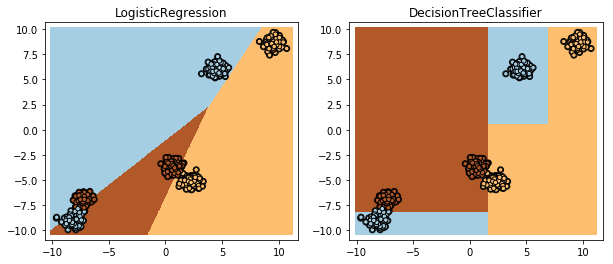

In [7]:
import numpy
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
h = .02
for i, model in enumerate([log, dec]):

    ax[i].scatter(X[:, 0], X[:, 1],
                  c=labels_true, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)

    ax[i].axis('tight')

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = model.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax[i].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax[i].scatter(X[:, 0], X[:, 1], c=labels_true, edgecolors='k', cmap=plt.cm.Paired)

    ax[i].set_title(str(model).split('(')[0])
ax;

La régression logistique est clairement moins performante mais pour la défendre, elle ne peut modèle qu'une partition convexe de l'espace des features. Autrement dit, si les classes à apprendre ne sont pas convexes, la régression logistique ne peut pas les modéliser. Deux options alors : soit changer pour un autre modèle non linéaire, soit ajouter des variables de telles sortes dans l'espace des features étendues, ce problèmes deviennent un problème de classes convexe.

## Utilisation des k-means

Et si on appliquait un [k-means](https://fr.wikipedia.org/wiki/K-moyennes) sur chacune des classes... C'est comme si on divisait chacune des classes en petits bouts convexes. Voyons jusqu'ou cela nous mène...